In [1]:
import pickle as pkl
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import networkx as nx
import os.path as op
import os
import csv
import math

%matplotlib inline

### Load all demographic + connectome data

(this is specific to total set files, so change to train/test when it comes to it)

remember not all are formatted exactly the same: degdist + meanconn differ from the rest (where meanconn is an array and degdist is a dictionary of dictionaries)

In [2]:
# dat connectome feature info
locstat = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_locstat.pkl','rb'))
nnonzero = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_nnonzero.pkl','rb'))
bwcent = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_bwcent.pkl','rb'))
edgewt = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_edgewt_new.pkl','rb'))
eigseq = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_eigseq.pkl','rb'))
cfclust = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_cfclust.pkl','rb'))
degdist = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_degdist.pkl','rb'))
meanconn = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_meanconn.pkl','rb'))

# dat TRAIN demographic info
age = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_ages.pkl', 'rb')) # dict of subjids: ages
behav = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_behav.pkl', 'rb')) # dict of subjids: {demog/cog: data}
subjids = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/total_subjids.pkl','rb')) # list of subjidsv

In [3]:
pdage_bins = {}
for subj in age:
    if age[subj] > 3 and age[subj] <= 6:
        pdage_bins['1'] = 1
        #print(age_bins[subj],age[subj])
    if age[subj] > 6 and age[subj] <= 9:
        pdage_bins['2'] = 2
    if age[subj] > 9 and age[subj] <= 12:
        pdage_bins['3'] = 3
    if age[subj] > 12 and age[subj] <= 15:
        pdage_bins['4'] = 4
    if age[subj] > 15 and age[subj] <= 18:
        pdage_bins['5'] = 5
    if age[subj] > 18:
        pdage_bins['6'] = 6

pdage_bins

#bages = [ x for x in set(age_bins.values()) if x==x ]
#len(bages)

{'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}

### Turn dictionaries in to dataframes

In [4]:
#meanconn is an array that does not need to be transformed into a df

behav_df = pd.DataFrame.from_dict(behav, orient='index')
# get rid of the NaNs so the binning next doesn't choke
# behav_nonan = behav_df.where((pd.notnull(behav_df)), None)
behav_nonan = behav_df.dropna(axis=0)

# df.isnull().values.any() -- useful code to check for NaNs!
# df.isnull().sum().sum() -- will tell you how many NaNs

locstat_df = pd.DataFrame.from_dict(locstat, orient='index')
nnonzero_df = pd.DataFrame.from_dict(nnonzero, orient='index')
bwcent_df = pd.DataFrame.from_dict(bwcent, orient='index')
edgewt_df = pd.DataFrame.from_dict(edgewt, orient='index')
eigseq_df = pd.DataFrame.from_dict(eigseq, orient='index')
cfclust_df = pd.DataFrame.from_dict(cfclust, orient='index')

for deg,sub in degdist.items():
    if deg == 'total_deg':
        degdist_df = pd.DataFrame.from_dict(sub,orient = 'index')

In [30]:
behav_nonan['Gender'].value_counts()

1.0    415
0.0    380
Name: Gender, dtype: int64

### Create cog bins with low/high labels
- issue: lots of NaNs where there shouldn't be (maybe because scores are not normalised)

### This is how you binned all ur shit (for future ref / debugging)
```
ranked = scipy.stats.rankdata(behav_nonan['TBX_flanker_score'])
data_percentile = ranked/len(behav_nonan['TBX_flanker_score'])*100
data_percentile

bins_percentile = [0,20,40,60,80,100]
data_binned_indices = np.digitize(data_percentile, bins_percentile, right=True)
data_binned_indices
```

In [7]:
a_bins = [ 3, 6, 9, 12, 15, 18, 22]
a_labels = ['1', '2', '3', '4', '5', '6']
# bins = [0, 2.5, 5, 7.5, 10] # percentage bins! (for pd.cut and np.digitize in older vers)
# bin_labels = ['Low', 'Low-Med','Med-High','High'] 
cogs = ['TBX_flanker_score','TBX_attention_score','TBX_ibam_scr','TBX_ls','TBX_VOCAB_THETA','TBX_reading_score', 
        'TBX_dccs_score','TBX_pspac_scr']

for cog in cogs:
    ranked = scipy.stats.rankdata(behav_nonan[cog])
    data_percentile = ranked/len(behav_nonan[cog])*100
    bins_percentile = [0,20,40,60,80,100]
    behav_nonan.loc[:,cog+'_binned'] = np.digitize(data_percentile, bins_percentile, right=True)

behav_nonan['Age_bins'] = pd.cut(behav_nonan['Age'], a_bins, labels=a_labels) # this one only needs to happen once

/Users/nalsharif/code/nooralsh/ping_proc/env/ping_analysis2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# WHAT ARE THESE DOING?

In [8]:
group_header = 'Age_bins'

group_stats = {}
groupby_data = behav_nonan.groupby([group_header])

In [9]:
data_header = 'TBX_flanker_score'

for group in "123456":
    data_from_group = groupby_data.get_group(group)[data_header]
    stat = np.mean(data_from_group)
    group_stats[group] = stat
    
group_stats

{'1': 4.674581073678572,
 '2': 7.0137179629248125,
 '3': 7.989349112426035,
 '4': 8.54936170212766,
 '5': 8.78952,
 '6': 8.897953216374267}

### Make a new column for every feature that is an average (mean) of each measure

- checks if subj exists in both df and then makes new col with avg info for that metric, along axis 1 which is (i think) along all ROIs

- eigeq mean ends up either 0 or 1.. is that correct?
- meanconn is already a mean and therefore not in this list but maybe should be added? but it doesn't have an index cause it's an array...


In [10]:
behav_nonan.loc[[x for x in locstat_df.index if x in behav_nonan.index],'avg_locstat'] = locstat_df.mean(axis=1)
behav_nonan.loc[[x for x in nnonzero_df.index if x in behav_nonan.index],'avg_nnonzero'] = nnonzero_df.mean(axis=1)
behav_nonan.loc[[x for x in bwcent_df.index if x in behav_nonan.index],'avg_bwcent'] = bwcent_df.mean(axis=1)
behav_nonan.loc[[x for x in edgewt_df.index if x in behav_nonan.index],'avg_edgewt'] = edgewt_df.mean(axis=1)
behav_nonan.loc[[x for x in eigseq_df.index if x in behav_nonan.index],'avg_eigseq'] = eigseq_df.mean(axis=1)
behav_nonan.loc[[x for x in cfclust_df.index if x in behav_nonan.index],'avg_cfclust'] = cfclust_df.mean(axis=1)
behav_nonan.loc[[x for x in degdist_df.index if x in behav_nonan.index],'avg_degdist'] = degdist_df.mean(axis=1)

#behav_nonan

### Might need to drop nans depending on what feature is being used

- be careful as this might delete more rows/columns than you intend
- as is, should only delete rows with NaNs

In [11]:
behav_data = behav_nonan.dropna(axis=0)

### Make models of cognition ~ age * connectome feature

- needs to loop through all features + all cog scores
- will make a model using statsmodels: cog_task ~ np.power(Age,2) * wm_feature + Age

In [12]:
wmfeats = ['avg_locstat','avg_nnonzero','avg_bwcent','avg_edgewt','avg_eigseq','avg_cfclust','avg_degdist']
cogtasks = ['TBX_flanker_score','TBX_reading_score','TBX_pspac_scr','TBX_ibam_scr','TBX_ls','TBX_dccs_score',
           'TBX_attention_score','TBX_VOCAB_THETA',]

for feat in wmfeats:
    for task in cogtasks:
        exec('model_{}_{} = smf.ols("{} ~ np.power(Age,2) * {} + Age", data = behav_data).fit()'.format(feat, task, task, feat)) 


In [13]:
model_avg_bwcent_TBX_attention_score.pvalues

Intercept                      1.799350e-05
np.power(Age, 2)               3.318153e-22
avg_bwcent                     7.502099e-01
np.power(Age, 2):avg_bwcent    9.131657e-01
Age                            2.642967e-74
dtype: float64

### Make a table of p-values from models for all features/tasks

In [14]:
from pandas.tools.plotting import table

mat = np.zeros((7,8))
for idx1,feat in enumerate(wmfeats):
    for idx2,task in enumerate(cogtasks):
        #print('idx1 {}: {}  || idx2 {}: {}'.format(idx1, feat, idx2, task))
        exec('mat[idx1,idx2] = model_{}_{}.pvalues[-2]'.format(feat,task))
    
#mat is an array of p-values which gets turned into a dataframe below

pvals_df = pd.DataFrame(mat,)
pvals_df.columns = ['Flanker Task','Reading Score','Processing Speed','Episodic Memory','Working Memory','DCCS Task',
                    'Attention Score','Vocabulary Score']
pvals_df.index = ['LocalStat','NoNonZero','Centrality','EdgeWeight','EigenSeq','ClustCoef','DegreeDist']
pvals_df

,Flanker Task,Reading Score,Processing Speed,Episodic Memory,Working Memory,DCCS Task,Attention Score,Vocabulary Score
LocalStat,0.692302,0.092728,0.105899,0.015043,0.496320,0.227434,0.402682,0.314227
NoNonZero,0.832067,0.054306,0.089715,0.103484,0.635347,0.205661,0.539150,0.105383
Centrality,0.933508,0.128783,0.059165,0.261100,0.911003,0.087786,0.913166,0.060524
EdgeWeight,0.843339,0.745018,0.644467,0.028248,0.580723,0.334525,0.804666,0.874109
EigenSeq,0.456116,0.110570,0.993624,0.930767,0.117690,0.492108,0.410855,0.533906
ClustCoef,0.080725,0.008070,0.114545,0.080124,0.221309,0.752254,0.658492,0.662207
DegreeDist,0.832067,0.054306,0.089715,0.103484,0.635347,0.205661,0.539150,0.105383


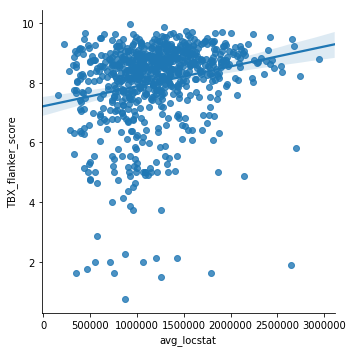

In [15]:
sns.lmplot("avg_locstat","TBX_flanker_score",data = behav_data)

### FDR-correction

In [16]:
from statsmodels.stats.multitest import multipletests

multipletests(mat.flatten(),method='fdr_bh')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False]),
 array([0.88111102, 0.31384032, 0.31384032, 0.31384032, 0.8160101 ,
        0.48985843, 0.74218993, 0.62845404, 0.94453997, 0.31384032,
        0.31384032, 0.31384032, 0.86240906, 0.47987557, 0.8160101 ,
        0.31384032, 0.9504809 , 0.32781068, 0.31384032, 0.54154047,
        0.9504809 , 0.31384032, 0.9504809 , 0.31384032, 0.94453997,
        0.91578766, 0.86240906, 0.31384032, 0.85580288, 0.64597896,
        0.94453997, 0.9504809 , 0.79820361, 0.31384032, 0.99362398,
        0.9504809 , 0.31384032, 0.8160101 , 0.74218993, 0.8160101 ,
      

### Bin the wm features

- maybe this can be done the same way as np.digitize above..?

In [17]:
test_df = behav_data # for testing purposes

In [18]:
def quantize(data,col):
    qntlz = data[col].quantile([0.25,0.5,0.75])
    
    for sub in data.index:
        scr = data.loc[sub,col]
             
        if scr < qntlz.loc[qntlz.index[0]]:
            data.loc[sub,'%s_binned'%col] = 'low'
        elif scr < qntlz.loc[qntlz.index[1]]:
            data.loc[sub,'%s_binned'%col] = 'low-med'
        elif scr < qntlz.loc[qntlz.index[2]]:
            data.loc[sub,'%s_binned'%col] = 'med-high'
        else:
            data.loc[sub,'%s_binned'%col] = 'high'
        
    return data

In [19]:
# loop through all wmfeatures to bin them
for feat in wmfeats:
    test_df = quantize(test_df,feat)

#test_df['avg_bwcent_binned'].value_counts()

### Figure out how to loop this

- u did it! but having all the cog scores AND wm feats was too much for the poor server so do each one on its own

In [29]:
len(test_df)

766

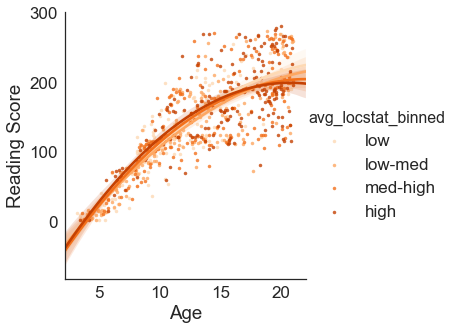

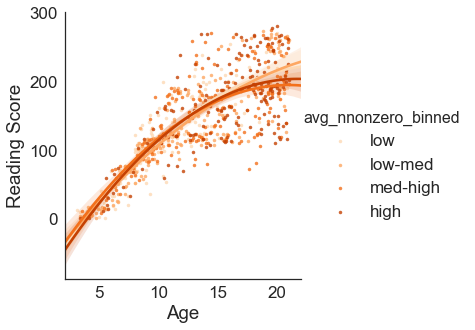

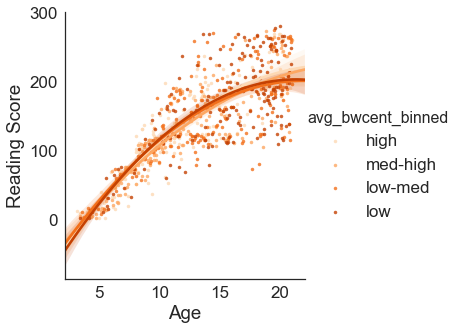

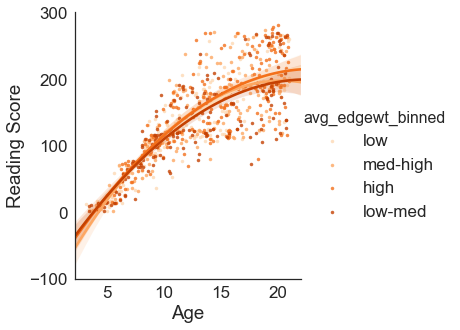

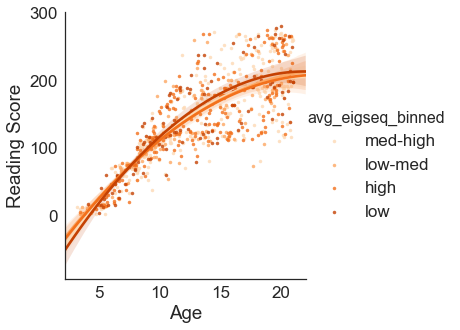

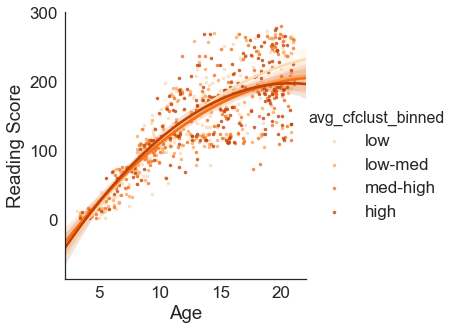

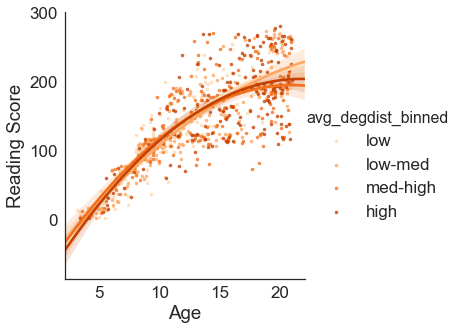

In [28]:
hues = ['avg_locstat_binned','avg_nnonzero_binned','avg_bwcent_binned','avg_edgewt_binned',
        'avg_eigseq_binned','avg_cfclust_binned','avg_degdist_binned']

for hue in hues:
    sns.set(font_scale=1.7)
    sns.set_style("white")        
    sns.set_palette("Oranges",4)
    exec('reading_{}_fig = sns.lmplot("Age","TBX_reading_score",data=test_df,hue=hue,order=2,markers=".")'.format(hue))
    #sns.lmplot("Age","TBX_reading_score",data=test_df,hue=hue,order=2,markers='.')
    #plt.title('Reading Score & '+hue) # this can be better titled
    exec('reading_{}_fig.set(xlabel="Age", ylabel="Reading Score")'.format(hue))
    exec('reading_{}_fig.savefig("/Users/nalsharif/science/PING/PING_bids/reading_{}_fig.png")'.format(hue, hue))

In [ ]:
exec('model_{}_{} = smf.ols("{} ~ np.power(Age,2) * {} + Age", data = behav_data).fit()'
     .format(feat, task, task, feat)) 
